In [18]:
import pickle as pkl
import numpy as np
import pandas as pd
import json
import sklearn
from sklearn import * 
from pytorch_v2 import TorchGame
from matplotlib import pyplot as plt
import torch
import numpy as np
import random

params_test = {
        "Horizon": 3, "Max_actions_chosen": 2, "N_actions_startpoint": 8, "I": .5, "D": 5,
        "Players_action_length": [5, 5], "Max_optim_iter": 75, "Filter_actions": True,
        "Stochastic_state_update": True, "base_params": "paper", "NumRepsBattle": 8,
        "DEVICE": "cpu", "MultiProcess": False
    }

game = TorchGame(**params_test) 
df = pd.read_pickle("saved_runs/COMBITECH/History.pkl")
df = df.loc[:,:]


          PlayerA_y  PlayerB_y
sen_tec           4          4
col_sys           2          2
tec_mob           3          3
cont_alg          5          5
loc_map           3          3
sen_fus           3          3
ai_ml             2          2
edg_com           2          2
com_net           4          4
ene_mgm           4          4
sim_mod           2          2
hum_man           3          3
cyb_sec           3          3
eth_reg           2          2
          sen_tec  col_sys  tec_mob  cont_alg  loc_map  sen_fus  ai_ml   
A,B             0        0        0         0        0        0      0  \
Phi, Psi        9        3        1         3        3        9      3   
n_a,n_b         3        3        1         3        1        3      9   
p_a,p_b         9        1        1         3        9        3      1   
n_y,n_z         9        9        9         3        3        9      3   
p_y,p_z         9        3        3         3        3        3      9   
u,v             0

In [19]:
print(df.State[0])
tmp = np.concatenate((df.State[0][:,0],df.State[0][:,1]),0)
print(tmp)
print(df.State[1])

df.State[0] = tmp

[[ 4.25146732  4.48302837]
 [ 7.54567182  2.07858718]
 [ 3.09124009  3.0273736 ]
 [ 5.55359183  5.30495089]
 [ 3.10770496  3.0012847 ]
 [ 3.25190689  6.49290895]
 [ 2.74779917  3.31414787]
 [ 2.10430046  2.37399047]
 [ 4.08086109  4.0468319 ]
 [ 4.06168093  4.08555494]
 [28.79734939  2.66359488]
 [ 3.09086156  3.0295573 ]
 [ 7.65495872  3.67193984]
 [ 3.81014726  2.01881237]]
[ 4.25146732  7.54567182  3.09124009  5.55359183  3.10770496  3.25190689
  2.74779917  2.10430046  4.08086109  4.06168093 28.79734939  3.09086156
  7.65495872  3.81014726  4.48302837  2.07858718  3.0273736   5.30495089
  3.0012847   6.49290895  3.31414787  2.37399047  4.0468319   4.08555494
  2.66359488  3.0295573   3.67193984  2.01881237]
[ 4.01734337  2.26115516  3.00822003  5.07411574  3.02639065  3.01888334
  2.0073692   2.24958785  4.2540662   4.16073324 16.76955414  3.00901107
  3.08635817  2.00075676  4.38634014  2.01384565  3.87087327  5.01672419
  3.1058045   3.11338207  2.08854359  2.0121506   4.00772592

C:\Users\IsakG\AppData\Local\Temp\ipykernel_8500\2097927292.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.State[0] = tmp


In [20]:
plt.style.use('bmh')
plt.rcParams["figure.facecolor"] = "D1E2FF"
plt.rcParams["axes.facecolor"] = "F2F8FF"

# display(plt.rcParams.keys())

In [21]:
nParams, nTech = game.PARAMCONVERSIONMATRIX.size()
print(nParams, nTech)

8 14


In [22]:
def plot_trl(old_state, new_state, action):
    nParams, nTech = game.PARAMCONVERSIONMATRIX.size()
    print(nParams, nTech)
    
    # act_norm = game.normAction(action)
    # new_state = game.Update_State(game.stack_var(state), action, False)

    old_state_A = old_state[:nTech]
    new_state_A = new_state[:nTech]
    
    old_trl_A = game.TechnologyReadiness(old_state_A).numpy()
    new_trl_A = game.TechnologyReadiness(new_state).numpy()

    
    old_state_B = old_state[nTech:]
    new_state_B = new_state[nTech:]
    
    old_trl_B = game.TechnologyReadiness(old_state_B).numpy()
    new_trl_B = game.TechnologyReadiness(new_state_B).numpy()
        
    state_grid = np.linspace(-1,12,1000)
    trl_base = game.TechnologyReadiness(torch.tensor(state_grid)).numpy()
    
    r, c = int(nTech/2), 2
    fig, axs = plt.subplots(r, c)
    fig.set_size_inches(16,28)
    for i in range(r):
        for j in range(c):
            k = 2*i + j
            # print(i,j,"-",k)
            # print(r,c)
            axs[i][j].plot(state_grid, trl_base)
            
            #old states
            axs[i][j].scatter(old_state_A[k].numpy(), old_trl_A[k], color="blue", alpha = .3)
            axs[i][j].scatter(old_state_B[k].numpy(), old_trl_B[k], color="red", alpha = .3)
            #new states
            axs[i][j].scatter(new_state_A[k].numpy(), new_trl_A[k], color="blue", alpha = 1)
            axs[i][j].scatter(new_state_B[k].numpy(), new_trl_B[k], color="red", alpha = 1)
            axs[i][j].set_title(game.TechnologyNames[k])
    fig.show()

def plot_act_theta(state, action):
    nParams, nTech = game.PARAMCONVERSIONMATRIX.size()
    
    action = game.stack_var(action)
    theta = game.techToParams(game.stack_var(state))
    
    theta_A = theta[:,0].numpy()
    action_A = action[:,0].numpy()
   
    theta_B = theta[:,1].numpy()
    action_B = action[:,1].numpy()
    
    fig, axs = plt.subplots(1,2)
    fig.set_size_inches(16,4)
    
    width = .5
    r = np.arange(nTech)
    axs[0].set_title("actions of each player")
    axs[0].bar(r, action_A, color="blue", width= width, label="Player1")
    axs[0].bar(r+width, action_B, color="red", width= width, label="Player2")
    # axs[1].xticks(r + width/2 , labels = game.ParamNames)
    axs[0].set_xticks(r + width/2)
    axs[0].set_xticklabels(labels = game.TechnologyNames)
    axs[0].legend()
    
    
    
    # width = .5
    r = np.arange(nParams)
    axs[1].set_title("battle Parameters of each player")
    axs[1].bar(r, theta_A, color="blue", width= width, label="Player1")
    axs[1].bar(r+width, theta_B, color="red", width= width, label="Player2")
    # axs[1].xticks(r + width/2 , labels = game.ParamNames)
    axs[1].set_xticks(r + width/2)
    axs[1].set_xticklabels(labels = game.ParamNames)
    axs[1].legend()



    # fig.show()
    fig.autofmt_xdate()
    
    
# df.Action[9]

In [23]:
# df[df.Node_id == 0].State.values

Index(['Node_id', 'Parent_id', 'Time', 'State', 'Action', 'Reward'], dtype='object')
0.0
8 14


C:\Users\IsakG\AppData\Local\Temp\ipykernel_8500\4021796310.py:41: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


tensor([ 4.2515,  7.5457,  3.0912,  5.5536,  3.1077,  3.2519,  2.7478,  2.1043,
         4.0809,  4.0617, 28.7973,  3.0909,  7.6550,  3.8101,  4.4830,  2.0786,
         3.0274,  5.3050,  3.0013,  6.4929,  3.3141,  2.3740,  4.0468,  4.0856,
         2.6636,  3.0296,  3.6719,  2.0188], dtype=torch.float64)
tensor([ 4.0173,  2.2612,  3.0082,  5.0741,  3.0264,  3.0189,  2.0074,  2.2496,
         4.2541,  4.1607, 16.7696,  3.0090,  3.0864,  2.0008,  4.3863,  2.0138,
         3.8709,  5.0167,  3.1058,  3.1134,  2.0885,  2.0122,  4.0077,  4.0378,
        11.1172,  3.0032,  3.2016,  2.0228], dtype=torch.float64)
tensor([1.5659e-05, 2.4063e-01, 2.5745e-04, 2.5036e-06, 1.0107e-05, 1.4512e-04,
        5.3596e-03, 1.0850e-06, 5.0774e-07, 7.4816e-07, 4.7535e+00, 3.8273e-05,
        7.8326e-07, 2.6969e-07, 1.0140e-08, 5.6363e-08, 1.8617e-09, 3.7708e-08,
        6.1052e-09, 1.7890e-08, 8.1034e-05, 2.7972e-09, 5.0019e-08, 1.2483e-09,
        4.9999e+00, 2.9830e-09, 5.7259e-09, 5.1182e-08])


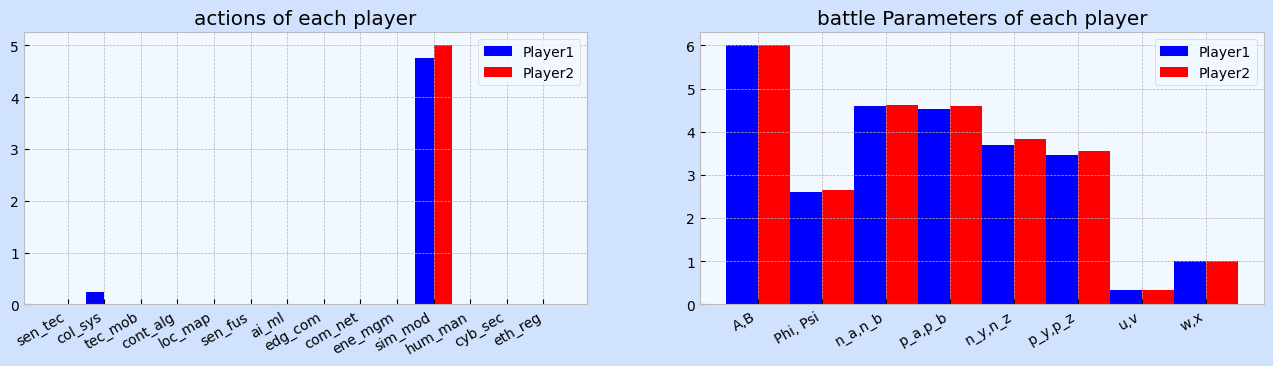

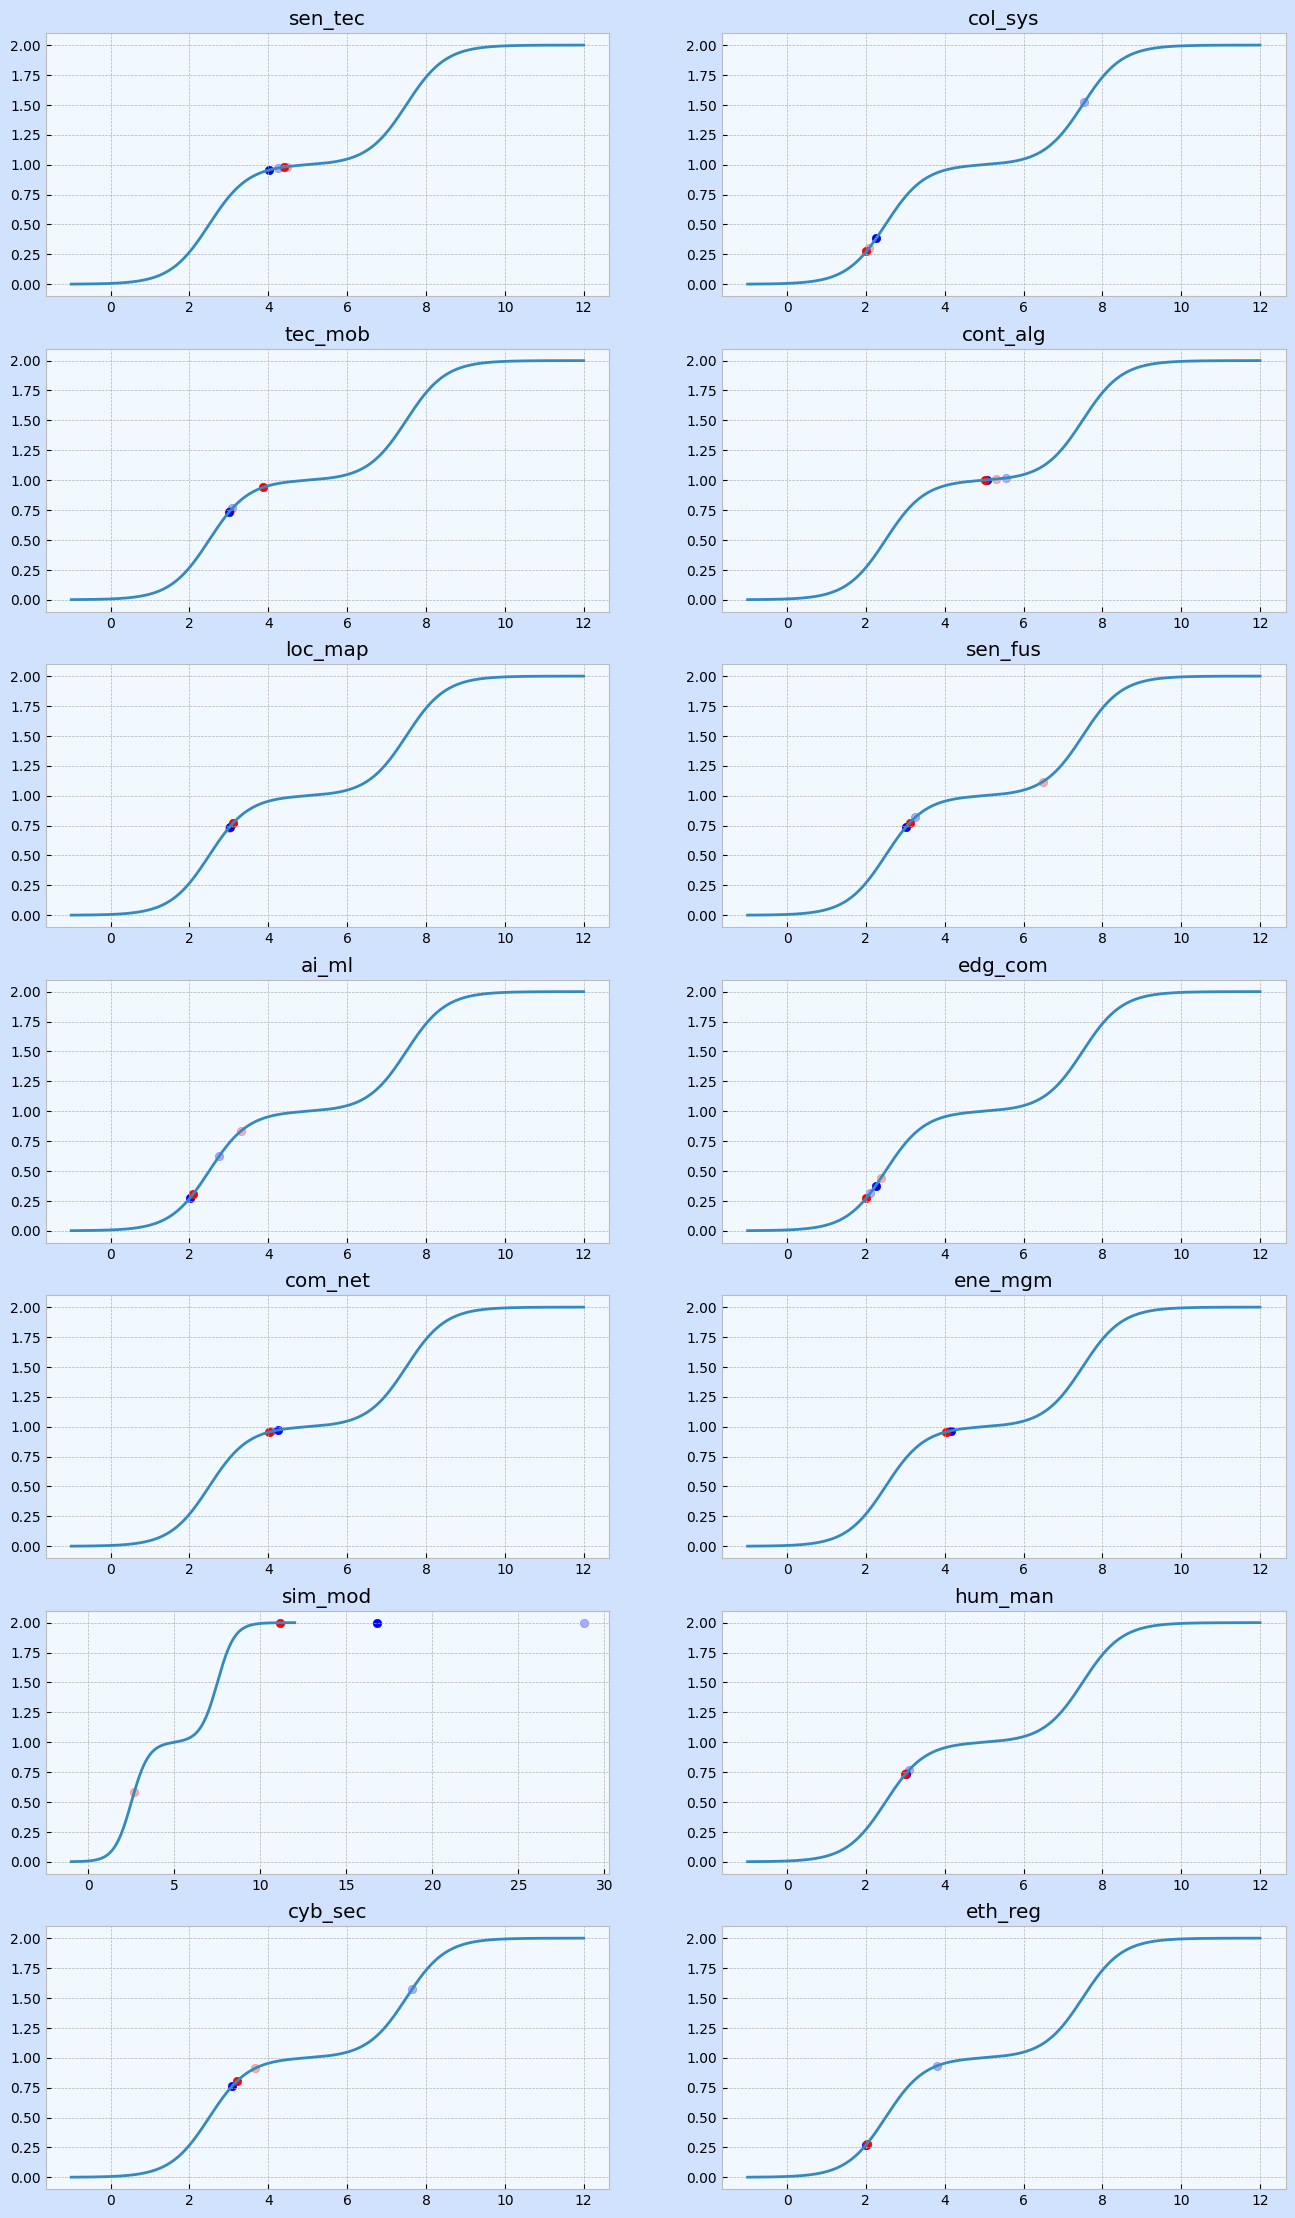

In [24]:

print(df.columns)
numPoints = len(df.index)
old_state_i = df.Parent_id
states =df.State
actions = df.Action

plot_ind = 1

p_id = df.loc[plot_ind,:].Parent_id
print(p_id)
old_state =  torch.tensor(df[df.Node_id == p_id].State.values.tolist()).squeeze()

new_state =  torch.tensor(states[plot_ind]).squeeze()

act = torch.tensor(actions[plot_ind]).squeeze()
plot_act_theta(new_state, act)
plot_trl(old_state,new_state, act)


print(old_state)
print(new_state)
print(act)

In [25]:
n = 10000
mu = torch.tensor([0.05]*n)
std = torch.tensor([1.5]*n)

dist = torch.distributions.log_normal.LogNormal(torch.tensor([0.05]*10), torch.tensor([1.5]*10), validate_args=None)
dist.rsample([1])
# draws_norm = torch.normal(mean=mu,std=std).exp()
# draws_lognorm = dist.rsample([n])

# plt.hist(draws_norm.numpy(), bins=100,density=True, color="red")

# plt.hist(draws_lognorm.numpy(), bins=100,density=True, color="blue")
# plt.show()

tensor([[0.3179, 1.5713, 2.2753, 1.6634, 0.4624, 1.8736, 2.0696, 2.5519, 0.7008,
         1.6906]])

In [26]:
# (.values.astype(np.float32))

acts = torch.tensor(df.Action.dropna().values.tolist())
# Vals.shape
# Vals[:,game.N_Technologies:]

C:\Users\IsakG\AppData\Local\Temp\ipykernel_8500\927654509.py:88: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()
C:\Users\IsakG\AppData\Local\Temp\ipykernel_8500\927654509.py:88: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()
C:\Users\IsakG\AppData\Local\Temp\ipykernel_8500\927654509.py:88: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()
C:\Users\IsakG\AppData\Local\Temp\ipykernel_8500\927654509.py:88: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()
C:\Users\IsakG\AppData\Local\Temp\ipykernel_8500\927654509.py:88: UserWarning: Matplotlib is currently using module://ma

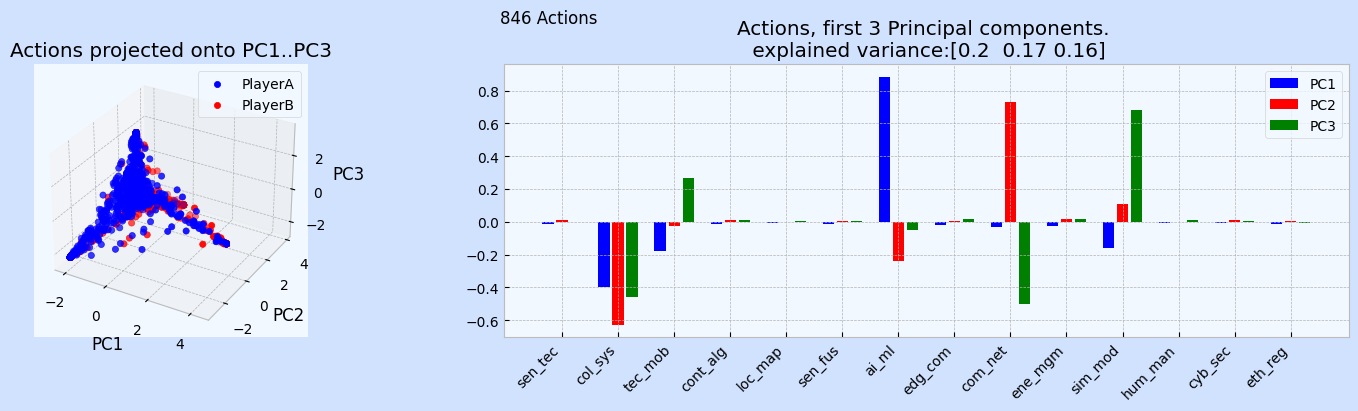

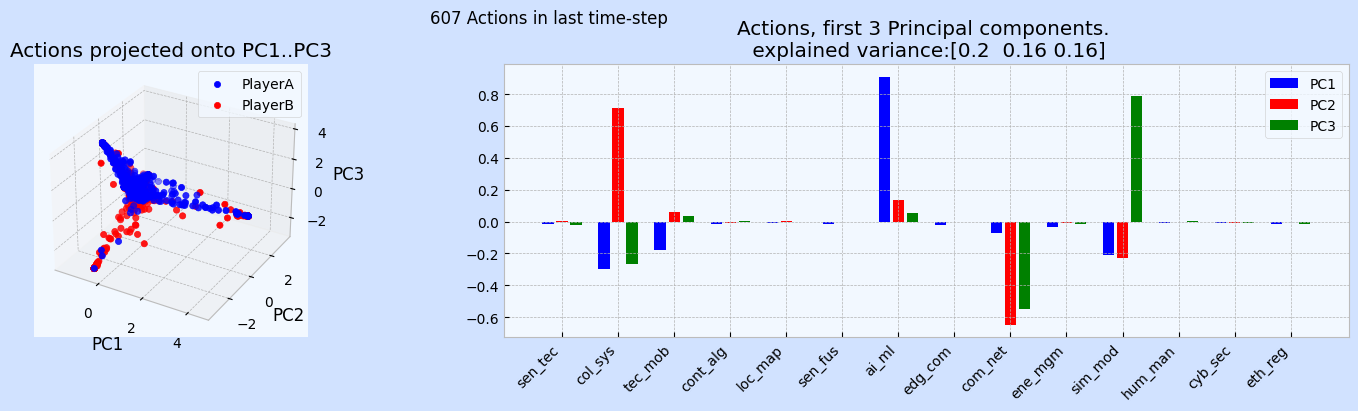

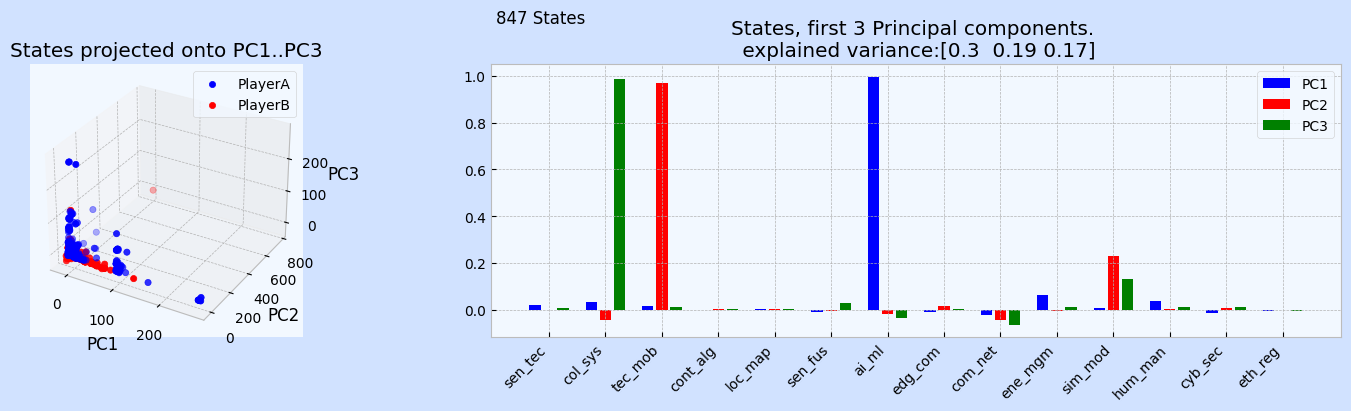

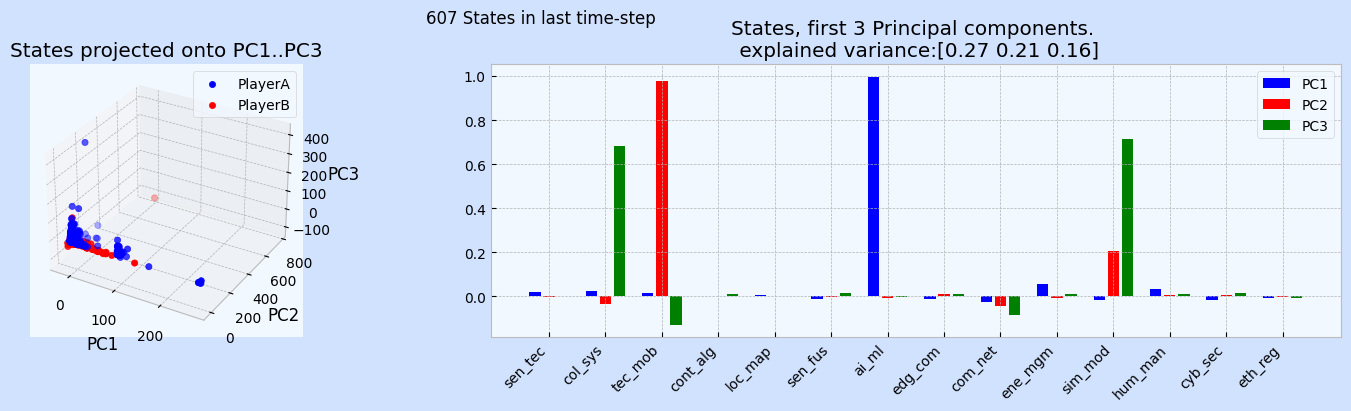

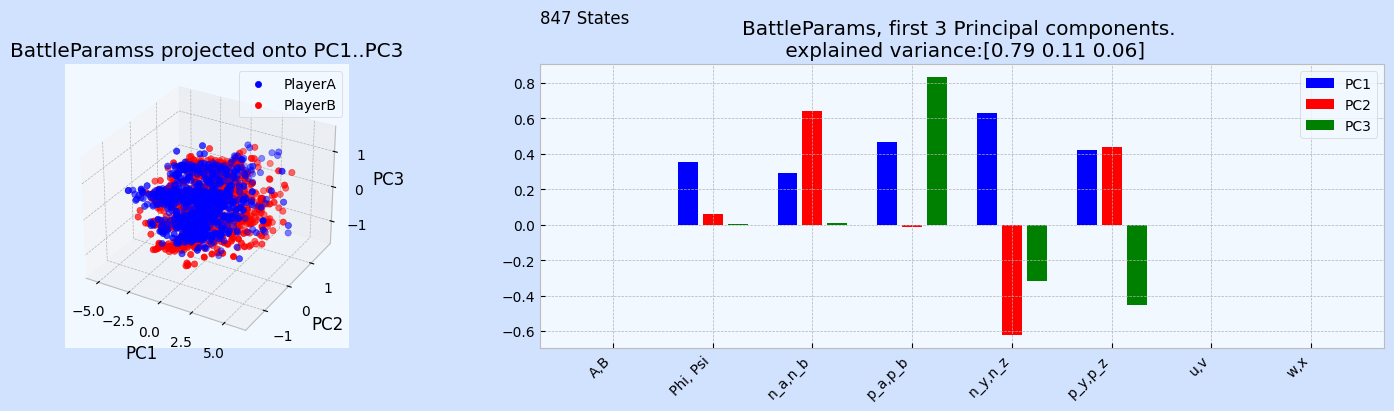

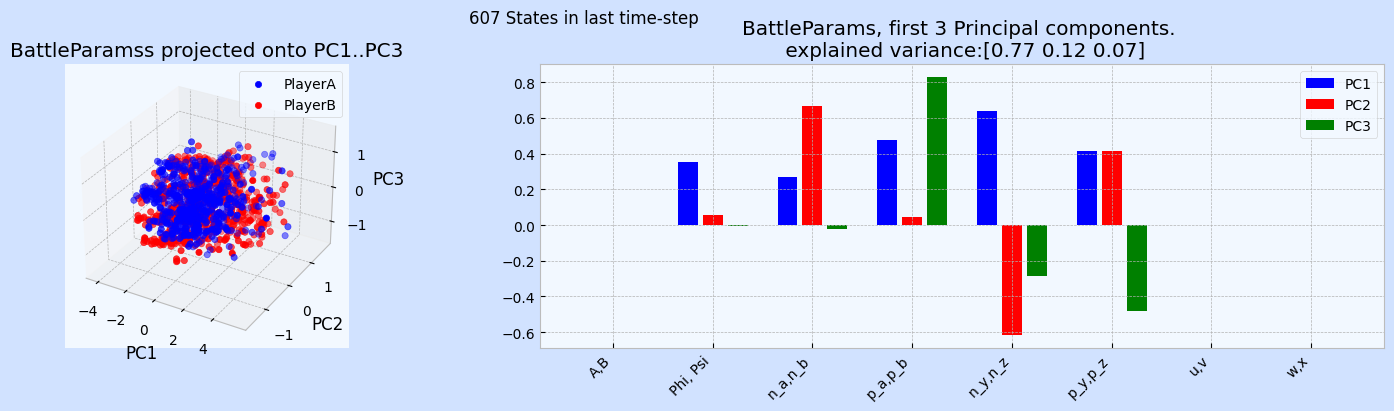

In [27]:
# num
def one_sided_pca_plot(df, key, t_max):
    if t_max:
        df = df[df.Time == df.Time.max()]
    if key == "Theta":
        key = "State"
        theta = True
    else: 
        theta = False
        
    vals = torch.tensor(getattr(df, key).dropna().values.tolist())
    numVals = vals.shape[0]
    if theta:
        thetas = []
        for i in range(numVals):
            # print(vals.shape)
            nTech = int(vals.shape[1] / 2)
            
            # a = vals[i,:nTech].T
            # b = vals[i,nTech:].T
            # print(a,b)
            state = game.stack_var(vals[i,:])
            # print(state)
            th = game.techToParams(state).numpy()
            thetas.append(th[:,0])            
            thetas.append(th[:,1])
            allVals = thetas
    else:
       
        valsA, valsB = (vals[:,:game.N_Technologies]).numpy(), (vals[:,game.N_Technologies:]).numpy()
        allVals = np.concatenate((valsA,valsB),0)
        
    
    pca = sklearn.decomposition.PCA(3)
    pca_fit_AB = pca.fit_transform(allVals)
    
    pca_fit_A = pca_fit_AB[:numVals,:]
    pca_fit_B = pca_fit_AB[numVals:,:]

    fig = plt.figure(figsize=(16,4))
    # fix , axs = plt.subplots(1,2,width_ratios=(1,3))
    # ax = axs[0]
    if t_max:
        fig.suptitle(f"{numVals} {key}s in last time-step")
    else:
        fig.suptitle(f"{numVals} {key}s")
        
    ax = fig.add_subplot(1,2, 1 ,projection='3d')

    ax.scatter(pca_fit_A[:,0], pca_fit_A[:,1], pca_fit_A[:,2], color="blue", label="PlayerA")
    ax.scatter(pca_fit_B[:,0], pca_fit_B[:,1], pca_fit_B[:,2], color="red", label="PlayerB")

    ax.set_xlabel('PC1')
    ax.set_ylabel('PC2')
    ax.set_zlabel('PC3')
    
    ax.set_title(f"{key if  not theta else 'BattleParams'}s projected onto PC1..PC3")
    
    ax.legend()
    
    
    components = pca.components_
    var = pca.explained_variance_ratio_
    
    nTech = np.shape(components[0])[0]
    nComps = len(components)
   
    ax2 = fig.add_subplot(1,2,2 )
    ax2.set_title(f"{key if  not theta else 'BattleParam' }s, first {nComps} Principal components. \n explained variance:{np.round(var,2)}")
    
   
    width = .5
    r = np.arange(nTech)
    
    ax2.bar(r, components[0], color="blue", width=1/5, label="PC1")
    ax2.bar(r + width/2, components[1], color="red", width=1/5, label="PC2")
    ax2.bar(r + width, components[2], color="green", width=1/5, label="PC3")
    if  theta:
        ax2.set_xticks(r + width/2, game.ParamNames, rotation = 45, ha="right")
    else:
        ax2.set_xticks(r + width/2, game.TechnologyNames, rotation = 45, ha="right")
    # ax2.set_xticklabels(labels = game.TechnologyNames)
    # ax2.set_x
    ax2.legend()
    
    
    fig.tight_layout(h_pad = 0, pad=0)
    fig.show()
    

one_sided_pca_plot(df,"Action", False)
one_sided_pca_plot(df,"Action", True)
one_sided_pca_plot(df,"State", False)
one_sided_pca_plot(df,"State", True)
one_sided_pca_plot(df, "Theta", False)
one_sided_pca_plot(df, "Theta", True)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
C:\Users\IsakG\AppData\Local\Temp\ipykernel_8500\2132238301.py:87: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
C:\Users\IsakG\AppData\Local\Temp\ipykernel_8500\2132238301.py:87: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
C:\Users\IsakG\AppData\Local\Temp\ipykernel_8500\2132238301.py:87: UserWarning: Matplot

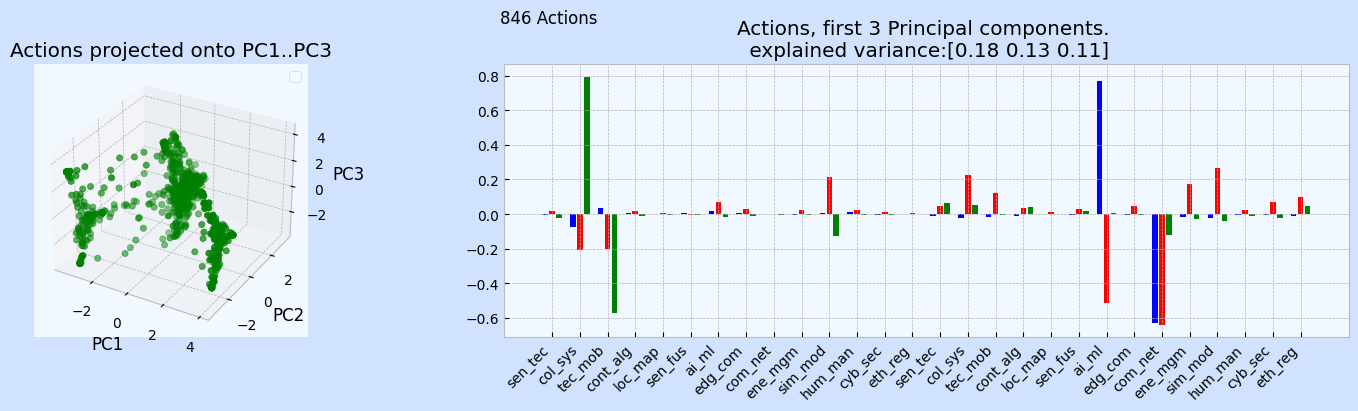

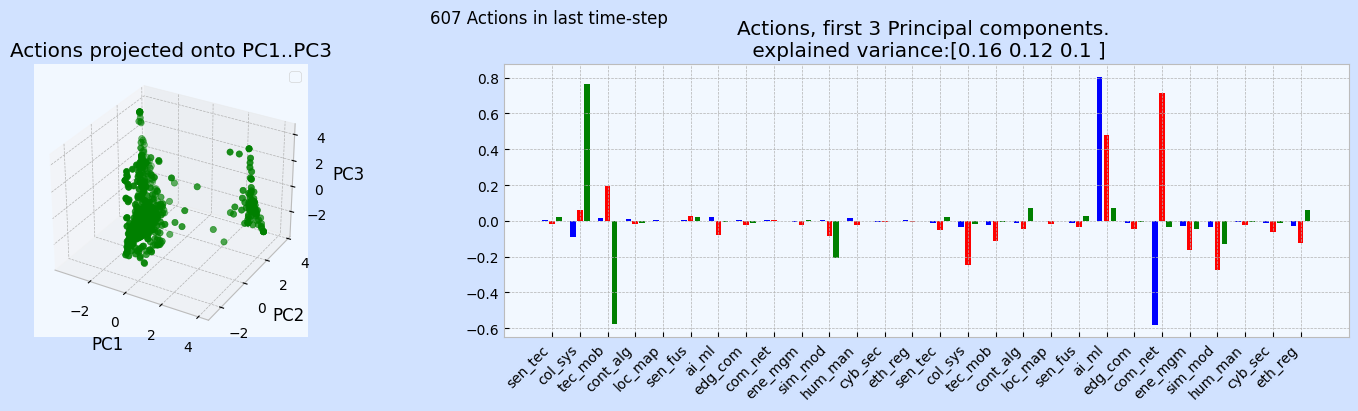

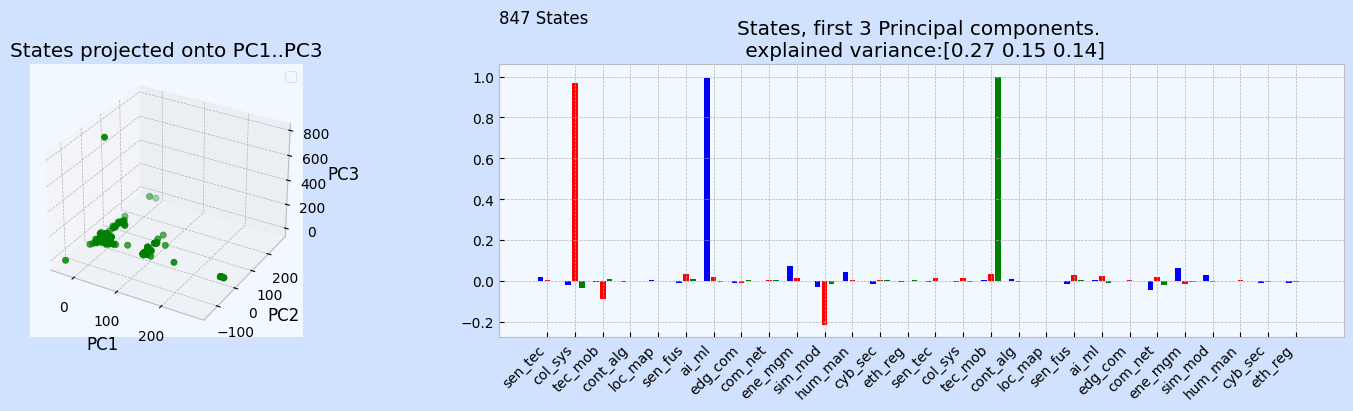

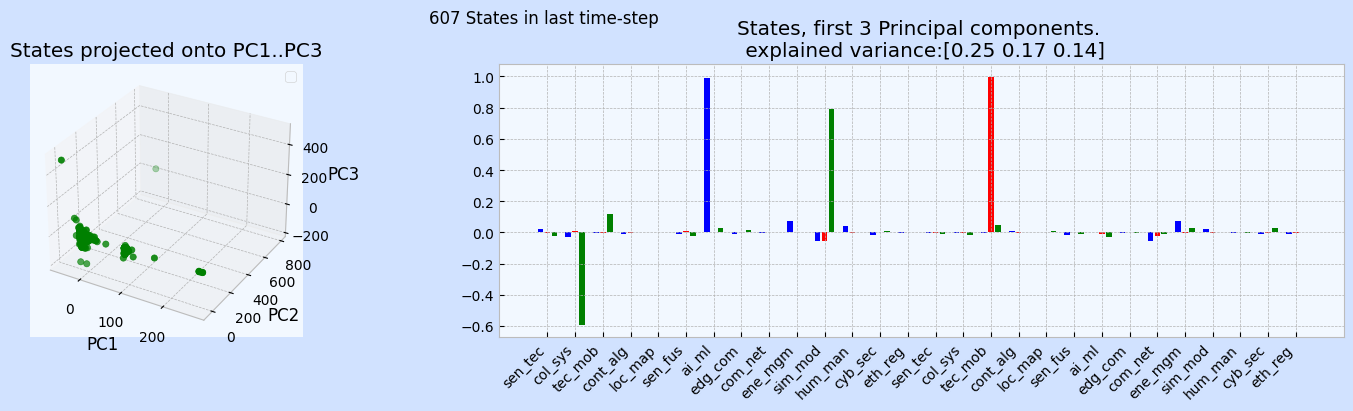

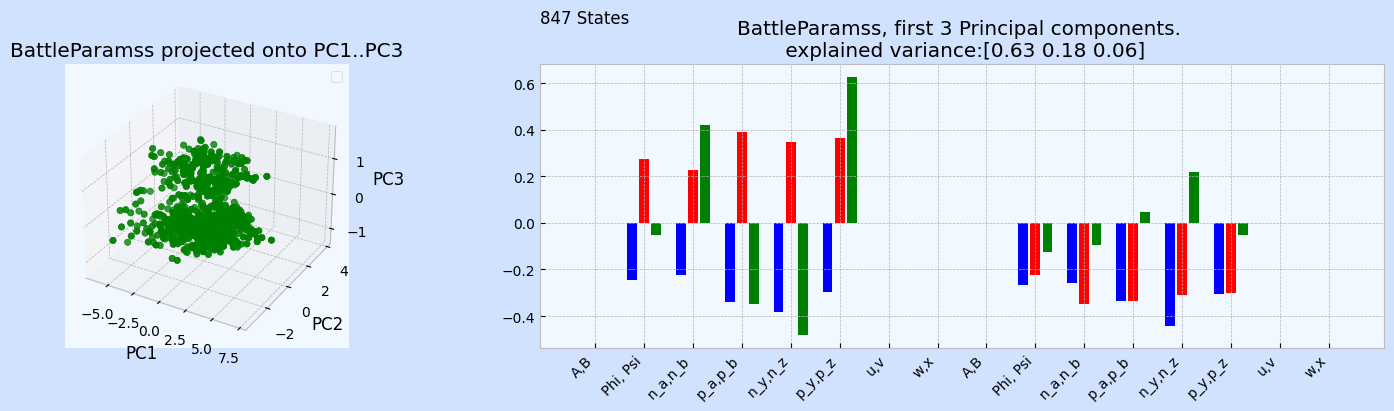

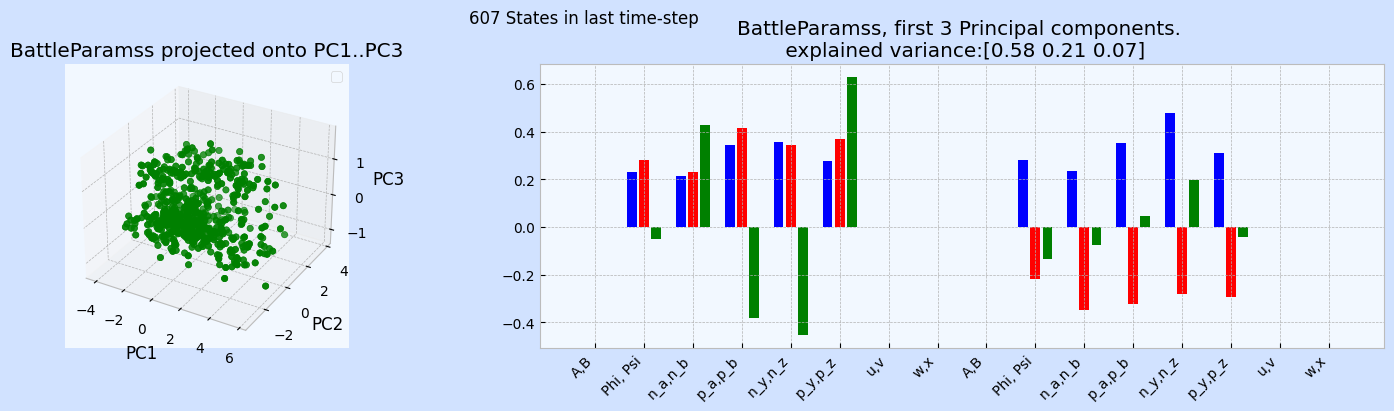

In [28]:
# num
def two_sided_pca_plot(df, key, t_max):
    if t_max:
        df = df[df.Time == df.Time.max()]
    if key == "Theta":
        key = "State"
        theta = True
    else: 
        theta = False
        
    vals = torch.tensor(getattr(df, key).dropna().values.tolist())
    numVals = vals.shape[0]
    if theta:
        thetas = []
        for i in range(numVals):
            # print(vals.shape)
            nTech = int(vals.shape[1] / 2)
            
            # a = vals[i,:nTech].T
            # b = vals[i,nTech:].T
            # print(a,b)
            state = game.stack_var(vals[i,:])
            # print(state)
            th = game.flatten_var(game.techToParams(state)).numpy()
            thetas.append(th)            
            thetas.append(th)
            allVals = thetas
    else:

        valsA, valsB = (vals[:,:game.N_Technologies]).numpy(), (vals[:,game.N_Technologies:]).numpy()
        allVals = np.concatenate((valsA,valsB),1)
        
    
    pca = sklearn.decomposition.PCA(3)
    pca_fit = pca.fit_transform(allVals)
    
    # pca_fit_A = pca_fit_AB[:numVals,:]


    fig = plt.figure(figsize=(16,4))
    # fix , axs = plt.subplots(1,2,width_ratios=(1,3))
    # ax = axs[0]
    if t_max:
        fig.suptitle(f"{numVals} {key}s in last time-step")
    else:
        fig.suptitle(f"{numVals} {key}s")
        
    ax = fig.add_subplot(1,2, 1 ,projection='3d')

    ax.scatter(pca_fit[:,0], pca_fit[:,1], pca_fit[:,2], color="green")

    ax.set_xlabel('PC1')
    ax.set_ylabel('PC2')
    ax.set_zlabel('PC3')
    
    ax.set_title(f"{key if  not theta else 'BattleParams'}s projected onto PC1..PC3")
    
    ax.legend()
    
    
    components = pca.components_
    var = pca.explained_variance_ratio_
    
    nTech = np.shape(components[0])[0]
    nComps = len(components)
   
    ax2 = fig.add_subplot(1,2,2 )
    ax2.set_title(f"{key if  not theta else 'BattleParams' }s, first {nComps} Principal components. \n explained variance:{np.round(var,2)}")
    
   
    width = .5
    r = np.arange(nTech)
    
    ax2.bar(r, components[0], color="blue", width=1/5, label="PC1")
    ax2.bar(r + width/2, components[1], color="red", width=1/5, label="PC2")
    ax2.bar(r + width, components[2], color="green", width=1/5, label="PC3")
    if  theta:
        ax2.set_xticks(r + width/2, game.ParamNames * 2, rotation = 45, ha="right")
    else:
        ax2.set_xticks(r + width/2, game.TechnologyNames * 2, rotation = 45, ha="right")
    # ax2.set_xticklabels(labels = game.TechnologyNames)
    # ax2.set_x
    # ax2.legend()
    
    
    fig.tight_layout(h_pad = 0, pad=0)
    fig.show()
    

two_sided_pca_plot(df,"Action", False)
two_sided_pca_plot(df,"Action", True)
two_sided_pca_plot(df,"State", False)
two_sided_pca_plot(df,"State", True)
two_sided_pca_plot(df, "Theta", False)
two_sided_pca_plot(df, "Theta", True)

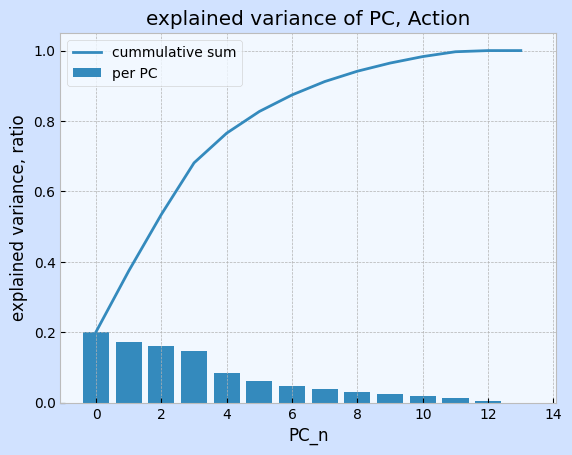

In [29]:
def all_pca_plot(df, key, t_max=False):
    if t_max:
        df = df[df.Time == df.Time.max()]
    vals = torch.tensor(getattr(df, key).dropna().values.tolist())
    
    # print(vals)
    numVals = vals.shape[0]
    valsA, valsB = (vals[:,:game.N_Technologies]).numpy(), (vals[:,game.N_Technologies:]).numpy()

    # print(valsA, valsB)
    pca = sklearn.decomposition.PCA()
    pca_fit_AB = pca.fit_transform(np.concatenate((valsA,valsB),0))
    
    evr = pca.explained_variance_ratio_
    
    fig, ax = plt.subplots(1,1)
    ax.set_title(f"explained variance of PC, {key}")
    ax.bar(range(pca.n_components_),evr, label="per PC")
    ax.plot(range(pca.n_components_),np.cumsum(evr), label ="cummulative sum")
    
    ax.set_xlabel("PC_n")
    ax.set_ylabel("explained variance, ratio")
    ax.legend(loc="best")    
all_pca_plot(df, "Action", False)

C:\Users\IsakG\AppData\Local\Temp\ipykernel_8500\2262667053.py:34: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


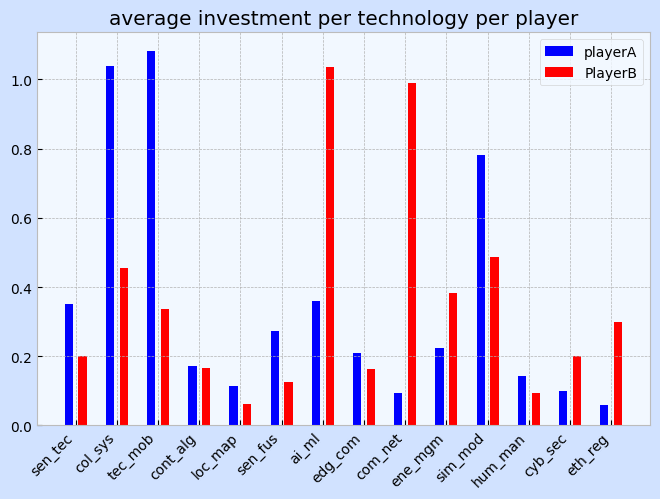

In [30]:
## Total capital invested normalised
Budget = [5,5]
nTech
actions = torch.tensor(df.Action[1:].values.tolist())
actionsA = actions[:,:nTech]
actionsB = actions[:,nTech:]

meansA = actionsA.mean(dim=0)
meansB = actionsB.mean(dim=0)

fig, ax = plt.subplots(1,1)
# ax2 = fig.add_subplot(1,2,2 )
ax.set_title(f"average investment per technology per player")


width = .5
r = np.arange(nTech)

ax.bar(r - width/3, meansA, color="blue", width=1/5, label="playerA")
ax.bar(r + width/3, meansB, color="red", width=1/5, label="PlayerB")
ax.set_xticks(r, game.TechnologyNames, rotation = 45, ha="right")
ax.legend()
# ax.bar(r + width, components[2], color="green", width=1/5, label="PC3")
# if  theta:
#     ax2.set_xticks(r + width/2, game.ParamNames * 2, rotation = 45, ha="right")
# else:
#     ax2.set_xticks(r + width/2, game.TechnologyNames * 2, rotation = 45, ha="right")
# ax2.set_xticklabels(labels = game.TechnologyNames)
# ax2.set_x
# ax2.legend()


fig.tight_layout(h_pad = 0, pad=0)
fig.show()

[15, 14, 10, 7, 3, 0]
6
[16, 14, 10, 7, 3, 0]
6
[17, 14, 10, 7, 3, 0]
6
[18, 13, 10, 7, 3, 0]
6
[19, 13, 10, 7, 3, 0]
6
[20, 13, 10, 7, 3, 0]
6
[21, 13, 10, 7, 3, 0]
6
[22, 13, 10, 7, 3, 0]
6
[23, 12, 10, 7, 3, 0]
6
[24, 12, 10, 7, 3, 0]
6


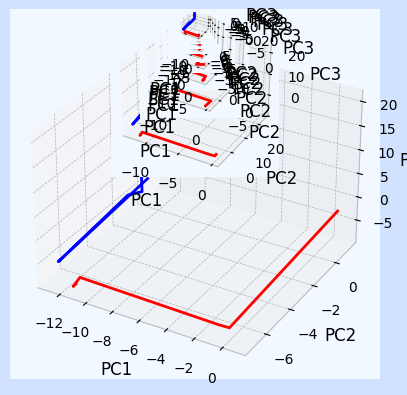

In [96]:
trajectories = []
pca = sklearn.decomposition.PCA(3)
vals = torch.tensor(getattr(df, "State").dropna().values.tolist())
valsA, valsB = (vals[:,:game.N_Technologies]).numpy(), (vals[:,game.N_Technologies:]).numpy()
allVals = np.concatenate((valsA,valsB),0)
# print(allVals.shape)
pca.fit(allVals)
states_A_pca = pca.transform(valsA)
states_B_pca = pca.transform(valsB)

# pca_fit = pca.fit_transform(allVals)

def get_trajectory(df, node_id):
    node_ids = [node_id]

    while node_id  != 0:
        node_id = int(df[df.Node_id == node_id].Parent_id.values[0])
        node_ids.append(node_id)
    # node_ids.append(0)
    return node_ids

leaf_nodes = df[df.Time == df.Time.max()].Node_id.values.tolist()
leaf_nodes
trajectories = []
for l_id in leaf_nodes:
    traj =  get_trajectory(df, node_id=l_id)
    # print(traj)
    trajectories.append(traj)
    
states = torch.Tensor(df[df.Node_id.isin(traj)].State.values.tolist())
# print(states.shape)
# statesA = states[:,:nTech].numpy()
# statesB = states[:,nTech:].numpy()
# statesA = pca.transform(statesA).tolist()
# statesB = pca.transform(statesB).tolist()

numPlots = 10
fig = plt.figure()
fig.add_gridspec(numPlots,1)
sample_idx = random.sample(range(len(trajectories)),numPlots)
for i, idx in enumerate(sample_idx):
    traj = trajectories[i]
    # fig = plt.figure()
    # fig.set_size_inches(6,6)
    
    """det är här det fakkar"""
    ax = fig.add_subplot(i+1,1,1,projection="3d")
    
    ax.set_xlabel('PC1')
    ax.set_ylabel('PC2')
    ax.set_zlabel('PC3')
    print(traj)
    states_A_pca_traj = states_A_pca[traj]
    states_B_pca_traj = states_B_pca[traj]
    # print(states_B_pca_traj)
    
    l = len(states_A_pca_traj)
    print(l)
    markers = [">"] + ["o"]*(l-2) + ["s"]
    ax.plot(states_A_pca_traj[:,0], states_A_pca_traj[:,1], states_A_pca_traj[:,2], color="blue")#, marker=markers)
    ax.plot(states_B_pca_traj[:,0], states_B_pca_traj[:,1], states_B_pca_traj[:,2], color="red")#, marker=markers)
    
